In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import matplotlib
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import visualization
from data import datasets
from transformation import MLP
import flax.linen as nn
from utils import MLPSymmetryHelper
import ipyvolume as ipv
import optax
import utils

cmap = matplotlib.cm.get_cmap("gist_rainbow")
rng_key = jax.random.PRNGKey(0)

In [2]:
#name = "mlp_4_1_izmailov_full_final"
name = "mlp_3_1_sinusoidal_0_8_final"
samples_parameters = jnp.load(name + ".npy")
print(samples_parameters.shape)

(8192, 10)


In [3]:
rng_key, rng_key_ = jax.random.split(rng_key)
kwargs = {"normalization": "standardization", "rng_key": rng_key_, "x_lower": 0.0, "x_upper": 8.0}
dataset = datasets.Sinusoidal(**kwargs)
#dataset = datasets.Izmailov(normalization="standardization")

In [4]:
transformation = MLP([3, 1], activation=nn.tanh)
sh = MLPSymmetryHelper(parameters_template=transformation.init(rng_key, jnp.ones(1)), activation_function="tanh")

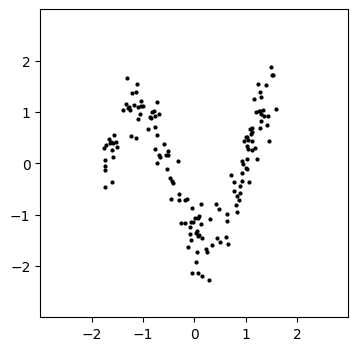

In [5]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(
            alpha=0.1,
            aleatoric=False,
            epistemic=False
        )
    ),
)
figure.plot(
    data=dataset.data,
    transformation=transformation.apply_from_vector,
    parameters_list=None, std=0.1
)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


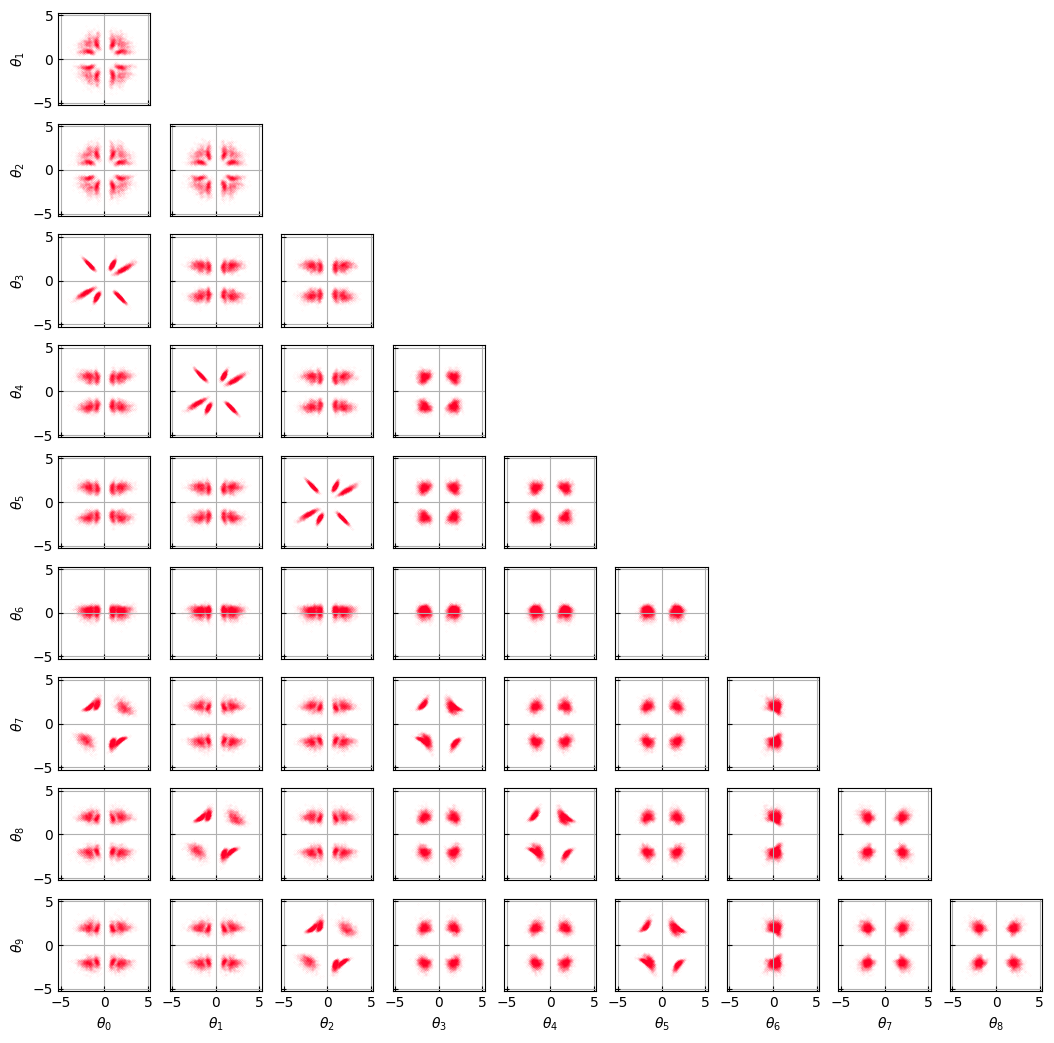

In [17]:
figure = visualization.TriangleFigure(
    settings=visualization.TriangleSettings(
        #ax_width=4.0,
        #ax_height=4.0,
        scatter_settings=visualization.ScatterSettings(
            alpha=0.1,
            size=0.1
        ),
        univariate=False
    )
)
figure.plot(
    data_list=[samples_parameters[:]]
)

In [33]:
figure.save("result_1_full_posterior.png")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:03<00:00, 314.66it/s]


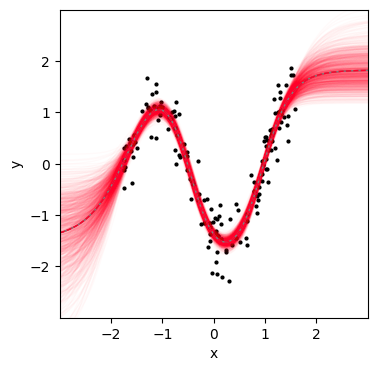

In [19]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(
            alpha=0.02,
        )
    ),
)
figure.plot(
    data=dataset.data,
    transformation=transformation.apply_from_vector,
    parameters_list=[samples_parameters[:1024]], std=0.3
)

In [20]:
figure.save("result_1_full_posterior_fs.png")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.89it/s]


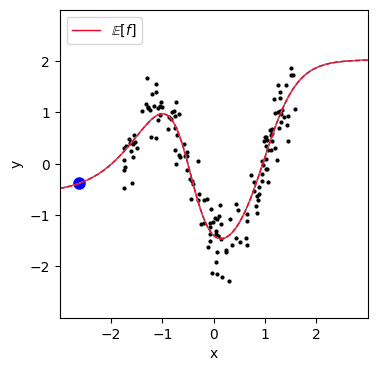

In [27]:
import numpyro.distributions as d

aleatoric = False
epistemic = False
aleatoric_std = 0.3
sele = 1
if epistemic:
    sele = 128

figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(
            alpha=0.04,
            aleatoric=aleatoric,
            epistemic=epistemic
        )
    ),
)
figure_ref = figure.plot(
    data=dataset.data,
    transformation=transformation.apply_from_vector,
    parameters_list=[samples_parameters[:sele]], std=aleatoric_std
)
axes = figure._figure.axes
axes[0].legend(loc="upper left")

# visualize a predictive uncertainty
x = np.linspace(-3, 3, 128)
means = jax.vmap(transformation.apply_from_vector, in_axes=(None, 0))(np.expand_dims(x, axis=-1), samples_parameters[:128]).squeeze(-1)
epistemic_stds = jnp.std(means, axis=0)
if aleatoric and not epistemic:
    mu = means[0][8]
    std = aleatoric_std
elif aleatoric and epistemic:
    mu = means.mean(0)[8]
    std = np.sqrt(aleatoric_std**2 + epistemic_stds[8]**2)
elif not aleatoric and not epistemic:
    mu = means[0][8]
else:
    mu = means.mean(0)[8]
    print(mu)
    std = epistemic_stds[8]

if aleatoric or epistemic:
    normal = d.Normal(jnp.array([mu]), jnp.array([std]))
    probs = jnp.exp(normal.log_prob(x))
    y = np.concatenate([np.linspace(0, 2, 16), np.linspace(2, 0, 16)])
    axes[0].plot(x[8] + probs, x, alpha=0.4, color="blue", linestyle="solid")
    #axes[0].plot(x[8] * np.ones(2), mu + np.linspace(-1.96, 1.96, 2) * std, alpha=0.4, color="blue", linestyle="solid")
    axes[0].plot(np.array([x[8], x[8] + np.max(probs)]), np.ones(2) * mu, alpha=0.4, color="blue", linestyle="dashed")
    axes[0].scatter(x[8], mu, color="blue", s=64)
else:
    axes[0].scatter(x[8], mu, color="blue", s=64)
figure_ref

In [28]:
figure.save(path="none.pdf")